# Sheet for processing and testing the robot data

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import time
df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/"
print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())

Index(['x', 'y', 'z', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')
11.7
GPU: True


### Data sorting

In [68]:
def sort_data(name):
    df = pd.read_csv(path+name)
    x=np.array([df['s1'],df['s2'],df['s3'],df['s4'],df['s5'],df['s6']])
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    print("X data:",x.shape,"\ny data:",y.shape)
    return x,y

X,y=sort_data("movementLeftFoot.csv")
X1,y1=sort_data("movementLeftFoot1.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("movementRightFoot.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("movementRightFoot1.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

X_,y_=gen_temporal_data(X,y,15)
print(X_.shape,y_.shape)


X data: (43558, 6) 
y data: (43558, 3)
X data: (25693, 6) 
y data: (25693, 3)
X data: (52583, 6) 
y data: (52583, 3)
X data: (15582, 6) 
y data: (15582, 3)
(137401, 90) (137401, 3)


### Regression

In [62]:
y=y_[:,2]
X_train, X_test, Y_train, Y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

Mean Squared Error: 0.00222


Time taken 1699283218.2603028


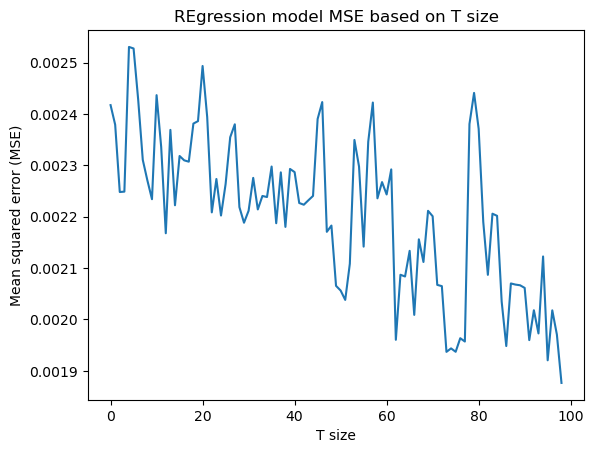

In [74]:
losses=[]
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y,t)
    y_=y_[:,2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses.append(mse)
print("Time taken",time.time()-t)
plt.plot(losses)
plt.title("Regression model MSE based on T size")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.show()

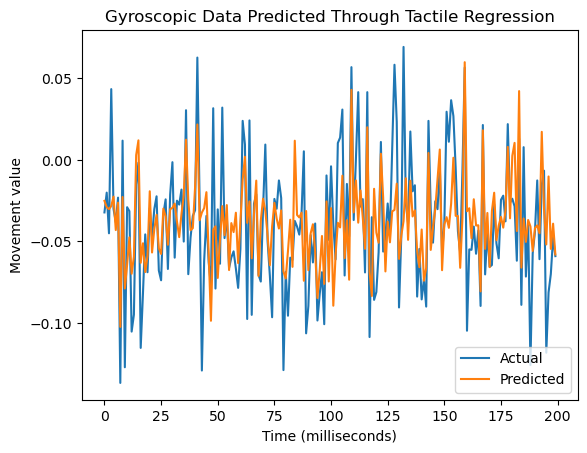

In [75]:
Y_pred = ridge_model.predict(X_train)
plt.plot(Y_train[0:200],label="Actual")
plt.plot(Y_pred[0:200],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()

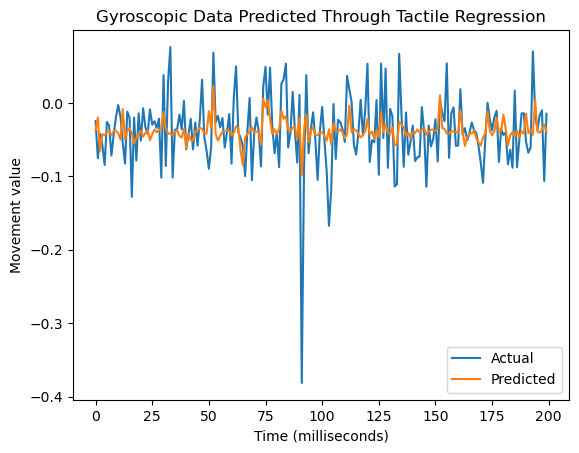

In [65]:
Y_pred = ridge_model.predict(X_test)
plt.plot(Y_test[0:200],label="Actual")
plt.plot(Y_pred[0:200],label="Predicted")


plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()


In [ ]:

"""
plt.plot(Y_pred[:,1][0:200],label="Predicted")
plt.plot(Y_test[:,1][0:200],label="Actual")
plt.plot(Y_pred[:,2][0:200],label="Predicted")
plt.plot(Y_test[:,2][0:200],label="Actual")
"""

### LSTM

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


#### Prep data

In [8]:
#prep data
X_,y_=gen_temporal_data_2(X,y,5)
#reduction
X_=(X_-np.average(X_))/np.std(X_)
y=(y-np.average(y))/np.std(y)
#split
X_train, X_test, Y_train, Y_test = train_test_split(X_.astype(np.float32)[0:100], y_.astype(np.float32)[0:100], test_size=0.2, random_state=42)
X_train=torch.tensor(X_train).to(device)
X_test=torch.tensor(X_test).to(device)
Y_train=torch.tensor(Y_train).to(device)
Y_test=torch.tensor(Y_test).to(device)

In [6]:
# Example usage:
input_size = 6
hidden_size = 64
num_layers = 2
output_size = 3

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

n = 10
input_data = X_train[0:n]
print(input_data.shape,input_data.dtype)
output = lstm_model(input_data)
print("LSTM Output:", output)

torch.Size([10, 5, 6]) torch.float32
LSTM Output: tensor([[-0.0802,  0.0379, -0.0586],
        [-0.0795,  0.0400, -0.0586],
        [-0.0787,  0.0389, -0.0611],
        [-0.0807,  0.0379, -0.0594],
        [-0.0801,  0.0381, -0.0574],
        [-0.0800,  0.0385, -0.0589],
        [-0.0803,  0.0371, -0.0564],
        [-0.0795,  0.0393, -0.0590],
        [-0.0786,  0.0413, -0.0602],
        [-0.0774,  0.0407, -0.0624]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


#### Training

In [9]:
def train(X_train,Y_train,X_test,Y_test,num_epochs = 100,learning_rate = 0.001):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],50,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()

        optimizer.zero_grad()
        # Forward pass
        outputs = lstm_model(X_train)

        # Calculate the loss
        loss = criterion(outputs, Y_train)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss = loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

        # Validation
        lstm_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            outputs = lstm_model(X_test)
            val_loss = criterion(outputs, Y_test)
            total_val_loss = val_loss.item()

            print(f"Validation Loss: {total_val_loss:.4f}")
            history_test.append(total_val_loss)
    # Save the trained model
    #torch.save(lstm_model.state_dict(), "lstm_model.pth")
    return history_train, history_test

lossTrain,lossTest=train(X_train,Y_train,X_test,Y_test,num_epochs = 1000,learning_rate = 0.01)

Epoch [1/1000], Loss: 37.5065
Validation Loss: 39.4443
Epoch [2/1000], Loss: 37.3708
Validation Loss: 39.5628
Epoch [3/1000], Loss: 37.1869
Validation Loss: 39.6825
Epoch [4/1000], Loss: 36.8560
Validation Loss: 39.6113
Epoch [5/1000], Loss: 36.2735
Validation Loss: 39.0104
Epoch [6/1000], Loss: 35.4710
Validation Loss: 38.2079
Epoch [7/1000], Loss: 34.7100
Validation Loss: 37.6412
Epoch [8/1000], Loss: 34.0141
Validation Loss: 37.7721
Epoch [9/1000], Loss: 33.4534
Validation Loss: 36.9035
Epoch [10/1000], Loss: 32.6880
Validation Loss: 36.0081
Epoch [11/1000], Loss: 31.8977
Validation Loss: 35.1913
Epoch [12/1000], Loss: 31.4384
Validation Loss: 34.8082
Epoch [13/1000], Loss: 30.6223
Validation Loss: 34.1416
Epoch [14/1000], Loss: 30.0191
Validation Loss: 33.4474
Epoch [15/1000], Loss: 29.1958
Validation Loss: 32.6653
Epoch [16/1000], Loss: 28.3721
Validation Loss: 32.0670
Epoch [17/1000], Loss: 27.3750
Validation Loss: 31.2717
Epoch [18/1000], Loss: 26.6203
Validation Loss: 30.7471
E

### Visualisation 

/tmp/ipykernel_30344/3896005188.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # You can choose different colormaps


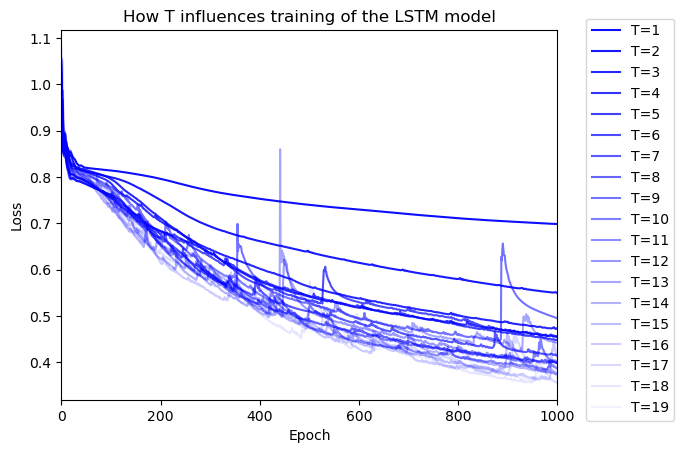

In [37]:
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20')  # You can choose different colormaps

filename="train_loss_t="

typ=".npy"
for i in range(1,20):
    shade=i/20
    data=np.load("/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/GPUCluster/data/"+filename+str(i)+"_"+typ)
    plt.plot(data,label="T="+str(i),color="b",alpha=1 - shade)

plt.title("How T influences training of the LSTM model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right",bbox_to_anchor=(1.25, 1.05))
plt.xlim([0,1000])
plt.show()

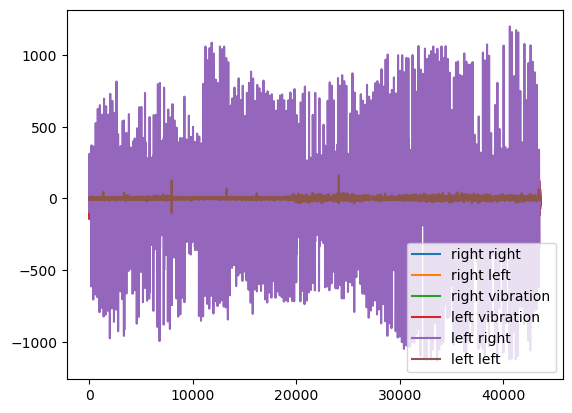

In [2]:
FROM=10
TO=-1
plt.plot(df['s1'][FROM:TO],label="right right")
plt.plot(df['s2'][FROM:TO],label="right left")
plt.plot(df['s3'][FROM:TO],label="right vibration")
plt.plot(df['s4'][FROM:TO],label="left vibration")
plt.plot(df['s5'][FROM:TO],label="left right")
plt.plot(df['s6'][FROM:TO],label="left left")
plt.legend(loc="lower right")
plt.show()

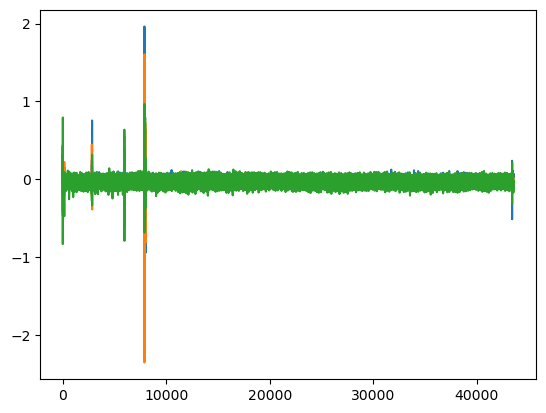

In [3]:
plt.plot(df['x'][FROM:TO])
plt.plot(df['y'][FROM:TO])
plt.plot(df['z'][FROM:TO])
plt.show()